In [ ]:
import json
import pandas as pd
file_name = 'user-wallet-transactions.json'
with open(file_name, 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data)
df.head()


,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'}
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'}
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'}
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'}
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'}


# New section

In [ ]:

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


df['amount'] = df['actionData'].apply(lambda x: float(x.get('amount', 0)) if isinstance(x, dict) else 0)

df[['userWallet', 'action', 'amount', 'timestamp']].head()


,userWallet,action,amount,timestamp
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,deposit,2.000000e+09,2021-08-17 05:29:26
1,0x000000000051d07a4fb3bd10121a343d85818da6,deposit,1.450000e+20,2021-05-20 15:36:53
2,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,1.000000e+15,2021-07-24 09:28:33
3,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,4.000000e+15,2021-07-31 23:15:18
4,0x0000000000e189dd664b9ab08a33c4839953852c,redeemunderlying,5.015480e+05,2021-04-19 15:25:07


In [ ]:

features = df.groupby('userWallet').agg(
    total_deposits=('amount', lambda x: x[df.loc[x.index, 'action'] == 'deposit'].sum()),
    total_borrows=('amount', lambda x: x[df.loc[x.index, 'action'] == 'borrow'].sum()),
    total_repaid=('amount', lambda x: x[df.loc[x.index, 'action'] == 'repay'].sum()),
    num_liquidations=('action', lambda x: (x == 'liquidationcall').sum()),
    num_actions=('action', 'count'),
    active_days=('timestamp', lambda x: x.dt.date.nunique())
).fillna(0)

features['repay_ratio'] = features['total_repaid'] / features['total_borrows'].replace(0, 1)
features['borrow_to_deposit_ratio'] = features['total_borrows'] / features['total_deposits'].replace(0, 1)
features.reset_index(inplace=True)

features.head()


,userWallet,total_deposits,total_borrows,total_repaid,num_liquidations,num_actions,active_days,repay_ratio,borrow_to_deposit_ratio
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,2.000000e+09,0.000000e+00,0.000000e+00,0,1,1,0.000000e+00,0.000000
1,0x000000000051d07a4fb3bd10121a343d85818da6,1.450000e+20,0.000000e+00,0.000000e+00,0,1,1,0.000000e+00,0.000000
2,0x000000000096026fb41fc39f9875d164bd82e2dc,5.000000e+15,0.000000e+00,0.000000e+00,0,2,2,0.000000e+00,0.000000
3,0x0000000000e189dd664b9ab08a33c4839953852c,0.000000e+00,0.000000e+00,0.000000e+00,0,17,8,0.000000e+00,0.000000
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,9.459366e+22,3.946000e+22,7.002457e+10,0,399,104,1.774571e-12,0.417153


In [ ]:
def calculate_score(row):
    score = 500


    score += 200 * row['repay_ratio']


    score -= 100 * row['borrow_to_deposit_ratio']


    score -= 50 * row['num_liquidations']


    score += 0.000000001 * row['total_deposits']
    score += 0.000000001 * row['total_repaid']


    score += 2 * row['active_days']


    score = max(0, min(1000, score))

    return score


features['credit_score'] = features.apply(calculate_score, axis=1)


features[['userWallet', 'credit_score']].head()


,userWallet,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,504.0
1,0x000000000051d07a4fb3bd10121a343d85818da6,1000.0
2,0x000000000096026fb41fc39f9875d164bd82e2dc,1000.0
3,0x0000000000e189dd664b9ab08a33c4839953852c,516.0
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,1000.0


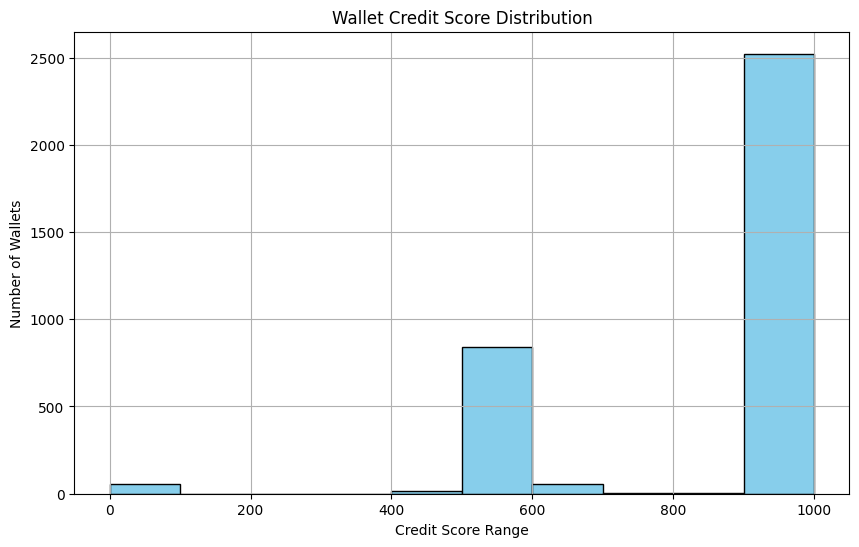

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(features['credit_score'], bins=10, edgecolor='black', color='skyblue')
plt.title('Wallet Credit Score Distribution')
plt.xlabel('Credit Score Range')
plt.ylabel('Number of Wallets')
plt.grid(True)
plt.show()


In [ ]:
features[['userWallet', 'credit_score']].to_csv('wallet_scores.csv', index=False)

from google.colab import files
files.download('wallet_scores.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

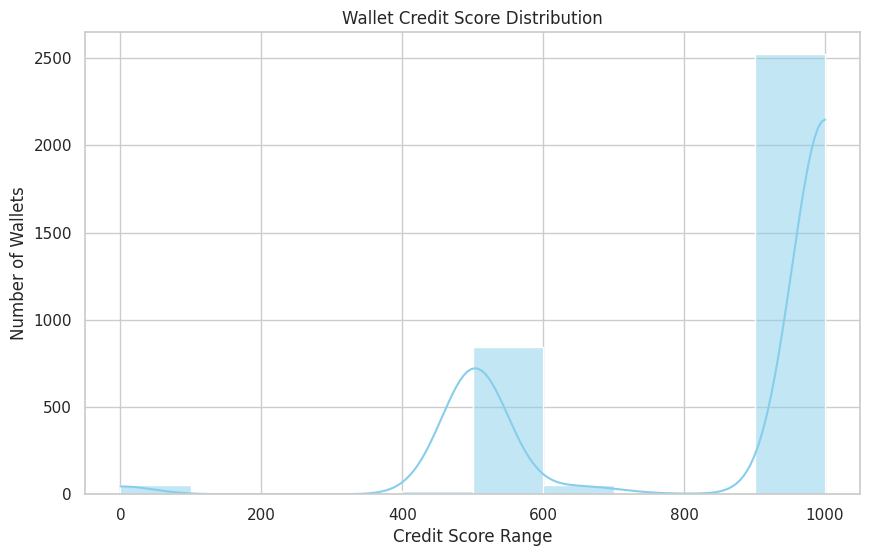

In [ ]:
import seaborn as sns
sns.set(style='whitegrid')
plt.figure(figsize=(10,6))
sns.histplot(features['credit_score'], bins=10, kde=True, color='skyblue')
plt.title('Wallet Credit Score Distribution')
plt.xlabel('Credit Score Range')
plt.ylabel('Number of Wallets')
plt.grid(True)
plt.show()


In [ ]:
plt.savefig("score_distribution.png")
files.download("score_distribution.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

SyntaxError: incomplete input (ipython-input-11-1981963145.py, line 1)